In [56]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset

import sys

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [25]:
transform = T.Compose([
    T.ToTensor(), # this will normalize image in range [0, 1]
    T.Normalize((0.5), (0.5)) # this will normalize image in range [-1, 1]
])
data = torchvision.datasets.FashionMNIST(root="../14-CNN Milestone Projects/fmnist", download=True, train=True, transform=transform)

In [28]:
data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [29]:
cat_1 = [1, 2, 7]
cat_2 = [1, 5, 7]

In [130]:
batchsize = 1000

In [131]:
cat_1_indices = [i for i, target in enumerate(data.targets) if target in cat_1]
cat_1_data = Subset(data, cat_1_indices)
cat_1_loader = DataLoader(cat_1_data, batch_size=batchsize, shuffle=True, drop_last=True)

In [132]:
len(cat_1_loader)

18

In [133]:
cat_2_indices = [i for i, target in enumerate(data.targets) if target in cat_2]
cat_2_data = Subset(data, cat_2_indices)
cat_2_loader = DataLoader(cat_2_data, batch_size=batchsize, shuffle=True, drop_last=True)

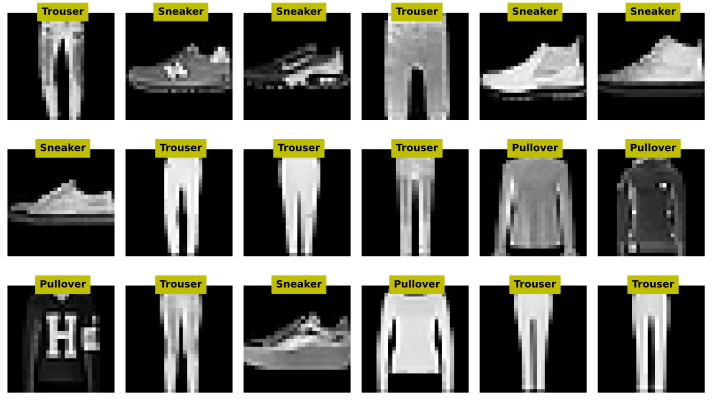

In [134]:
# view some images
# inspect a few random images

X,y = next(iter(cat_1_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = data.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [123]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,256)
        self.out = nn.Linear(256,1)

    def forward(self,x):
        x = x.view(-1, int(28*28))
        x = F.leaky_relu( self.fc1(x) )
        x = F.leaky_relu( self.fc2(x) )
        x = self.out(x)
        return torch.sigmoid( x )

In [124]:
# test

dnet = discriminatorNet()
y = dnet(torch.randn(10, 28, 28))
y

tensor([[0.4748],
        [0.4765],
        [0.4746],
        [0.4713],
        [0.4732],
        [0.4575],
        [0.4769],
        [0.4888],
        [0.4620],
        [0.4643]], grad_fn=<SigmoidBackward0>)

In [125]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )

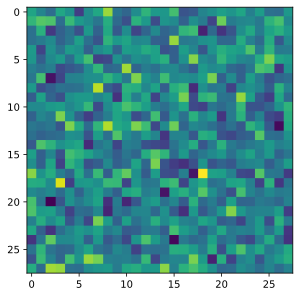

In [126]:
# test

gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28))
plt.show()


In [140]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [139]:
def trainModel(train_loader: DataLoader, dnet, gnet, d_optimizer, g_optimizer, lossfun):
    num_epochs = 500

    losses  = np.zeros((num_epochs,2))
    disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

    for epochi in range(num_epochs):

        for x, y in train_loader:
            real_images = x.to(device)
            fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator


            # labels used for real and fake images
            real_labels = torch.ones(batchsize,1).to(device)
            fake_labels = torch.zeros(batchsize,1).to(device)



            ### ---------------- Train the discriminator ---------------- ###

            # forward pass and loss for REAL pictures
            pred_real   = dnet(real_images)              # REAL images into discriminator
            d_loss_real = lossfun(pred_real,real_labels) # all labels are 1
            
            # forward pass and loss for FAKE pictures
            pred_fake   = dnet(fake_images)              # FAKE images into discriminator
            d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0
            
            # collect loss (using combined losses)
            d_loss = d_loss_real + d_loss_fake
            losses[epochi,0]  = d_loss.item()
            disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

            # backprop
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            
            

            ### ---------------- Train the generator ---------------- ###

            # create fake images and compute loss
            fake_images = gnet( torch.randn(batchsize,64).to(device) )
            pred_fake   = dnet(fake_images)
            
            # compute and collect loss and accuracy
            g_loss = lossfun(pred_fake,real_labels)
            losses[epochi,1]  = g_loss.item()
            disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()
            
            # backprop
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        
        # print out a status message
        
        msg = f'Finished epoch {epochi+1}/{num_epochs}'
        sys.stdout.write('\r' + msg)
        
    return losses, disDecs, dnet, gnet
  

In [141]:
# training on cat_1

losses, disDecs, dnet, gnet = trainModel(cat_1_loader, dnet, gnet, d_optimizer, g_optimizer, lossfun)

Finished epoch 500/500

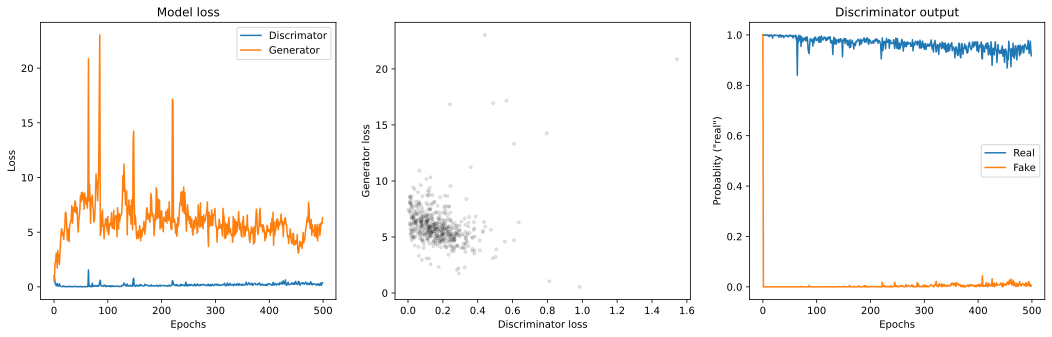

In [142]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[:,0],losses[:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

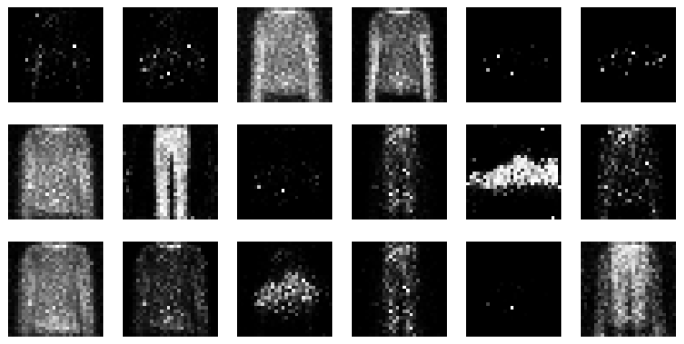

In [143]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(18,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

# plt.suptitle(classes2keep,y=.95,fontweight='bold')
plt.show()

### Training taking a lot of time